In [1]:
###########################################################################
### 
### The below code implements the nudged elastic band (NEB) method
###   of optimizing a path through a differentiable energy
###   landscape. The path is expressed as a series of linked 
###   "beads", or "images", each representing the system at an 
###   intermediate state between the pre-defined beginning/ending states. 
### 
### The gist is that in each iteration of the algorithm, each 
###   bead's velocity depends on its neighbors on either side (forward
###   and backward in the path) and on the energy landscape. The 
###   bead's energy gradient is calculated and is then projected 
###   onto the hyperplane orthogonal to the tangent direction 
###   (locally parallel to the path). The tangent component of 
###   velocity is calculated by considering each bead to be 
###   connected to its neighbors by springs and projecting the net
###   spring force onto the tangent direction. As a result, the 
###   algorithm "nudges" the path towards low-energy transitions
###   while preventing the beads from merging together in low-energy 
###   wells. This approach shows promise for constrained path optimization.
### 
### This code was modified from Casper Steinmann's Python 
###   implementation, which can be viewed here:
### 
###         https://github.com/cstein/neb
### 
###########################################################################

import numpy as np
from tqdm import tqdm

In [2]:
class NEB(object):
    """ A Nudged Elastic Band implementation
        This NEB implementation is based on http://dx.doi.org/10.1063/1.1323224
        by Henkelman et al.
    """
    def __init__(self, path, k):
        """ Initialize the NEB with a predefined path and force
            constants between images.
            Typical use-case might look like:
            >>> m1 = molecule_from_xyz('m1.xyz')
            >>> m2 = molecule_from_xyz('m2.xyz')
            >>> apath = neb.interpolate.Linear(m1, m2, 10)
            >>> neb = neb.Neb(apath, 5.0)
            >>> eandg = somefunction
            >>> minimizer = neb.minimizers.SteepestDescent
            >>> neb.minimize(100, 0.01, eandg, minimizer)
            Arguments:
            path -- Path between two endpoints to be optimized
            k -- force constant in units of eV / A^2 between each bead in the path
        """
        
        # Set initial path
        self._path = path.copy()
        
        # Get number of beads, molecules, and dimensions
        self._nb, self._n, self._d = self._path.shape
        
        # Set spring constant
        self._k    = k

        # Initialize NEB state
        bead_vals = np.zeros_like(self._path, dtype=np.float32)
        self._tangents      = bead_vals.copy()
        self._springforces  = bead_vals.copy()
        self._beadgradients = bead_vals.copy()
        self._forces        = bead_vals.copy()
        
        self._energies      = np.zeros(self._nb, dtype=np.float32)
        self._grms          = -np.ones(self._nb, dtype=np.float32)
        
        # Calculate tangents and springforces for the initial state
        self._beadTangents()
        self._springForces()

    def innerBeads(self):
        """ an iterator over the inner beads """
        for i, bead in enumerate(self._path):
            if i > 0 and i < self._nb-1:
                yield bead

    def innerBeadForces(self):
        """ iterator over the forces of the inner beads """
        for i, bead in enumerate(self.innerBeads(), start=1):
            yield self._forces[i]

    def _beadTangents(self):
        """ Evaluates all tangents for all the inner beads """
        for ibead, bead in enumerate(self.innerBeads(), start=1):
            self._tangents[ibead] = self._beadTangent(*self._path[(ibead-1):(ibead+2)])

    def _beadTangent(self, Rm, Ri, Rp):
        """ Calculates the tangent for the i'th given the bead
            indexed by i-1 (m) and i+1 (p).
            Calculated according to eq 2 in http://dx.doi.org/10.1063/1.1323224
            Arguments:
            Rm -- coordinates of the current (i'th) bead
            Ri -- coordinates of the (i-1)'th bead to use in the calculation of the tangent
            Rp -- coordinates the (i+1)'th bead to use in the calculation of the tangent
            Returns:
            tangent vector of the bead
        """
        vm = Ri - Rm
        vp = Rp - Ri
        ti = vm / np.linalg.norm(vm) + vp / np.linalg.norm(vp);
        return ti / np.linalg.norm(ti)

    def _springForces(self):
        """ Evaluates all spring forces between the beads """
        for ibead, bead in enumerate(self.innerBeads(), start=1):
            self._springforces[ibead] = self._springForce(*self._path[(ibead-1):(ibead+2)], self._tangents[ibead])

    def _springForce(self, Rm, Ri, Rp, tangent):
        """ Calculates the spring force for ibead given the bead
            indexed by i-1 (mbead) and i+1 (pbead).
        """
        
        # old spring force calculated according
        # to eq 5 in http://dx.doi.org/10.1063/1.1323224
        r = np.dot(np.ravel(Rp + Rm - 2*Ri), np.ravel(tangent))

        return self._k * r * tangent

    def _beadGradients(self, func):
        """ Calculates the forces on each bead using the func supplied
            Calculated according to eq 4 in http://dx.doi.org/10.1063/1.1323224
            Arguments:
            bead -- the bead whose internal force is to be evaluated
            func -- function that returns energy and forces for a bead
            Returns:
            e, g -- internal energy and force with component projected out
        """
        if func is None:
            return

        for ibead, bead in enumerate(self.innerBeads(), start=1):
            energy, gradient = func(bead)
            tangent = self._tangents[ibead]

            grad_perp = np.dot(np.ravel(gradient), np.ravel(tangent))

            # calculate regular NEB bead gradient
            self._beadgradients[ibead] = gradient - grad_perp * tangent

            self._energies[ibead] = energy

    def _beadGRMSs(self):
        """ Calculates RMSs of all bead force vectors.
        """
        for ibead, bead in enumerate(self.innerBeads(), start = 1):
            self._grms[ibead] = self._beadGRMS(self._forces[ibead])
        
    def _beadGRMS(self, force):
        """ Calculates the RMS of the total force on a bead
        """
        f = force.ravel()
        return np.sqrt(f.dot(f)/len(f))

    def beadForces(self, func):
        """ Calculates the forces of all 'inner' beads
            Arguments:
            func -- function that returns energy and forces for a bead
        """
        # Get force components
        self._beadTangents()
        self._springForces()
        
        # Calculate gradients and energies
        self._beadGradients(func)
        # print(self._energies.max())
        
        # Calculate net forces
        self._forces = self._springforces - self._beadgradients
        # print(self._forces.max())
        
        # Calculate statistics
        self._beadGRMSs()
    
    
    def minimize(self, nsteps, func, minimizer, opttol=0.01, progress=False, print_out=False):
        """ Minimizes the NEB path
            The minimization is carried out for nsteps to a tolerance
            of opttol with the energy and gradients calculated
            for each bead by func. The minimizer used is suppplied
            via the minimizers argument.
            When the method ends, one can iterate over all the beads
            in this class to get the states and continue from there.
            NOTE: The opttol argument is not active
            Arguments:
            nsteps -- perform a maximum of nsteps steps
            opttol -- the maximum rms gradient shall be below this value
            func -- energy and gradient function
            minimizer -- a minimizer
        """

        # Set up output strings
        s1 = "-"*50 + "\nstep {0:3d}\tmax(E) = {1:.6f}\t"
        _s2 = "  E ="
        # s3 = " F RMS = {0:9.4f}"
        # s4 = " F SPR = {0:9.4f}"
        
        if print_out:
            
            self._beadGradients(func)
            
            s2 = _s2 + " {:.4e}" * self._nb
            print(s1.format(i, maxE))
            print(s2.format(*self._energies))
        
        iterator = range(nsteps)
        if progress:
            iterator = tqdm(iterator)
        
        for i in iterator:
            
            # Calculate NEB forces
            self.beadForces(func)
            
            # Evolve the optimization
            step = minimizer.step(self._energies[1:-1], self._forces[1:-1])
            # print(step)
            self._path[1:-1] += step
            
            
#             grms = 0.0
#             grmsnrm = 0
#             for ibead, bead in enumerate(self.innerBeads(), start=1):
#                 f = np.ravel(self._forces[ibead])
#                 grms += np.linalg.norm(f)
#                 grmsnrm += len(f)

#                 s2 += "{0:9.4f}".format(self._energies[ibead])
#                 s3 += "{0:9.4f}".format(self._grms[ibead])
#                 s4 += "{0:9.4f}".format(np.max(self._springforces[ibead]))
            
            if print_out:
                maxE = max(self._energies[1:-1])
                s2 = _s2 + " {:.4e}" * self._nb
                print(s1.format(i + 1, maxE))
                print(s2.format(*self._energies))
                # print s3
                # print s4
        
        return self._path

In [3]:
# Optimization method for each bead. Takes energy and force and
#   returns a velocity vector for the bead.

class SteepestDescent(object):
    """ The Steepest Descent method takes a step along
        the direction of the force
        R_i+1 = R_i + k * F_i
        where k is the stepsize.
    """
    def __init__(self, stepsize=1.0e-3, eps=1.0e-2, verbose=False):
        self._stepsize = stepsize
        self._eps = eps
        self._verbose = verbose

    def step(self, energy, force):
        return self._stepsize * force

In [4]:
# The energy functional that defines the system state energy, as well
#    as the energy gradient. Here, I use a toy example of exponential
#    repulsion between molecules/cells. 

from scipy.spatial.distance import pdist, squareform

def exponential_repulsion(X, freeze=(), epsilon=0.5, sigma=1.0, dtype=np.float32):
    """Energy and forces on molecules with repulsion such that the potential
    between molecules i and j is E_ij = epsilon * exp(-r_ij / sigma)
    """
    
    # Pairwise distance
    D = pdist(X)
    
    # Compute potentials
    E = np.sum(epsilon * np.exp(-D / sigma))
    
    # Compute forces
    n = X.shape[0]
    D = squareform(D)
    F = np.zeros_like(X, dtype=dtype)
    for i in range(n):
        if i not in freeze:
            for j in range(n):
                if i != j:
                    fmag = epsilon / sigma * np.exp(-D[i, j] / sigma)
                    F[i] += fmag * (X[j] - X[i])

    return E, F

---

In [5]:
####### Running the NEB path optimization

import numpy as np
import cell_lattices as cx

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["figure.facecolor"] = "black"
plt.rcParams["axes.facecolor"] = "black"
plt.rcParams["text.color"] = "white"
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["figure.titlesize"] = 14


In [7]:
# Make a lattice configuration of cells
rows = cols = 9
X = cx.hex_grid(rows, cols, sigma=0.)

# Define 3 cells that will rotate positions
swapping_cells = np.array([31, 39, 41])

# Get the indices of cells on the border, which will remain fixed
frozen_idx = cx.get_outer_idx(rows, cols)

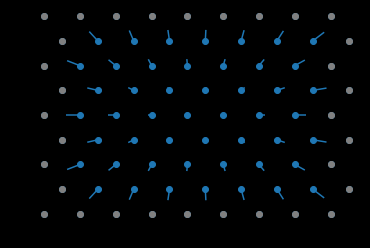

In [31]:
# Visualize the initial system state and energy gradient

from matplotlib.collections import LineCollection

fig, ax = plt.subplots()

# original cell positions in blue
plt.scatter(*X.T)

# trajectory of repulsion
X_repulsed = 0.25 * exponential_repulsion(X, freeze=frozen_idx)[1]
segs = np.zeros((X.shape[0], 2, 2))
segs[:, 0, :] = X
segs[:, 1, :] = X - X_repulsed
line_segments = LineCollection(segs)
ax.add_collection(line_segments)

# fixed cells in gray
plt.scatter(*X[frozen_idx].T, color="gray")

In [11]:
# Define the final state
X_final = X.copy()
X_final[swapping_cells] = X[np.roll(swapping_cells, 1)]

# Construct a linear path with `nt` time-steps (beads)
nt       = 75
t        = np.linspace(0, 1, nt)
lin_path = np.array([(1 - _t) * X + _t * X_final for _t in t])

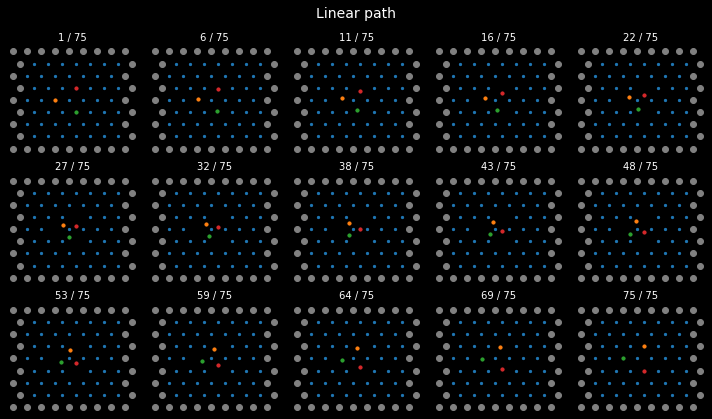

In [13]:
# Plot the linear path 

fig, axs = plt.subplots(3, 5, figsize=(10, 6))

plt.suptitle("Linear path")

nplot = len(axs.flat)
sample_idx = np.array([int(k) for k in np.linspace(0, nt - 1, nplot)])

for i, ax in enumerate(axs.flat):
    _X = lin_path[sample_idx[i]]
    ax.scatter(*_X.T, s=5)
    ax.scatter(*_X[frozen_idx].T, color="gray")
    for j in range(3):
        ax.scatter(*_X[swapping_cells[j]], s=10)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(f"{sample_idx[i] + 1} / {nt}")

plt.tight_layout()

In [14]:
# Make an NEB optimizer object
neb = NEB(lin_path, 1.0)

# Define the function for energy minimization 
minimizer = SteepestDescent(stepsize=0.01, )    # Gradient descent

# Make a wrapper function that takes the system state and returns
#   energy (E) and the energy gradient (G)
EG_func = lambda x: exponential_repulsion(x, freeze=frozen_idx)

In [15]:
# Run NEB optimization
nsteps   = 100
neb_path = neb.minimize(nsteps, EG_func, minimizer, progress=True)

100%|████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


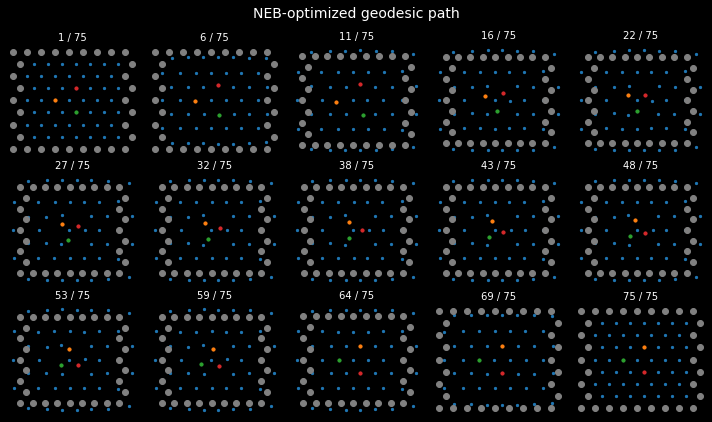

In [16]:
# PLot the optimized path

fig, axs = plt.subplots(3, 5, figsize=(10, 6))

plt.suptitle("NEB-optimized geodesic path")

for i, ax in enumerate(axs.flat):
    _X = neb_path[sample_idx[i]]
    ax.scatter(*_X.T, s=5)
    ax.scatter(*_X[frozen_idx].T, color="gray")
    for j in range(3):
        ax.scatter(*_X[swapping_cells[j]], s=10)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(f"{sample_idx[i] + 1} / {nt}")

plt.tight_layout()

Writing to: /home/pbhamidi/git/cell-lattices/plots/Linear_NEB_paths_toy_.mp4
Frame 1 / 75
Frame 2 / 75
Frame 3 / 75
Frame 4 / 75
Frame 5 / 75
Frame 6 / 75
Frame 7 / 75
Frame 8 / 75
Frame 9 / 75
Frame 10 / 75
Frame 11 / 75
Frame 12 / 75
Frame 13 / 75
Frame 14 / 75
Frame 15 / 75
Frame 16 / 75
Frame 17 / 75
Frame 18 / 75
Frame 19 / 75
Frame 20 / 75
Frame 21 / 75
Frame 22 / 75
Frame 23 / 75
Frame 24 / 75
Frame 25 / 75
Frame 26 / 75
Frame 27 / 75
Frame 28 / 75
Frame 29 / 75
Frame 30 / 75
Frame 31 / 75
Frame 32 / 75
Frame 33 / 75
Frame 34 / 75
Frame 35 / 75
Frame 36 / 75
Frame 37 / 75
Frame 38 / 75
Frame 39 / 75
Frame 40 / 75
Frame 41 / 75
Frame 42 / 75
Frame 43 / 75
Frame 44 / 75
Frame 45 / 75
Frame 46 / 75
Frame 47 / 75
Frame 48 / 75
Frame 49 / 75
Frame 50 / 75
Frame 51 / 75
Frame 52 / 75
Frame 53 / 75
Frame 54 / 75
Frame 55 / 75
Frame 56 / 75
Frame 57 / 75
Frame 58 / 75
Frame 59 / 75
Frame 60 / 75
Frame 61 / 75
Frame 62 / 75
Frame 63 / 75
Frame 64 / 75
Frame 65 / 75
Frame 66 / 75
Frame 67

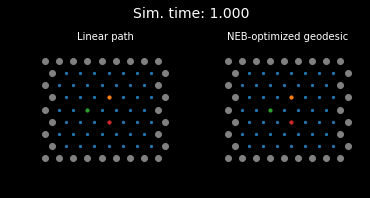

In [17]:
# Make an animation!

import os
import matplotlib as mpl
from matplotlib import animation

save_dir      = os.path.abspath("./plots")
fpath         = os.path.join(save_dir, f"Linear_NEB_paths_toy_.mp4")
dpi           = 300


save     = True
n_frames = 75
writer   = "ffmpeg"
fps      = 12

xlim = -5.15, 5.65
ylim = -4.55, 4.55


if save:

    # Get which frames to animate
    nt = t.size
    frames = cx.vround(np.linspace(0, nt-1, n_frames))

#     # Font sizes
#     SMALL_SIZE  = 12
#     MEDIUM_SIZE = 14
#     BIGGER_SIZE = 16

#     plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#     plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#     plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#     plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    # Make figure
    fig, axs = plt.subplots(
        nrows=1, 
        ncols=2, 
        figsize=(6, 3),
    )
    for ax in axs:
        ax.set_aspect("equal")
        ax.axis("off")
    
    # Update which data is used for each run, in each frame
    var_kw = dict(X = X, title = "")
    def update_kw(f, pathtype):
        var_kw.update(
            X     = (lin_path, neb_path)[pathtype][frames[f]],
            title = ("Linear path", "NEB-optimized geodesic")[pathtype],
        )

    # Plot one frame of animation
    def make_frame(f):

        # print(f"Frame {f+1} / {n_frames}")

        # Set title at top of figure
        plt.suptitle(f"Sim. time: {frames[f] / (nt - 1):.3f}")

        # Iterate through a 1 x 2 layout of plots
        for idx, ax in enumerate(axs.flat):

            # Update plotting params
            update_kw(f, idx)

            # Clear axis
            ax.clear()

            # All cells
            ax.scatter(*var_kw["X"].T, s=5)
            
            # Fixed cells
            ax.scatter(*var_kw["X"][frozen_idx].T, color="gray")
            
            # Moving cells
            for j in range(3):
                ax.scatter(*var_kw["X"][swapping_cells[j]], s=10)
            
            # Options
            ax.set_title(var_kw["title"])
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
    
    try:
        _writer = animation.writers[writer](fps=fps, bitrate=1800)
    except RuntimeError:
        print("""
        The `ffmpeg` writer must be installed inside the runtime environment.
        Writer availability can be checked in the current enviornment by executing 
        `matplotlib.animation.writers.list()` in Python. Install location can be
        checked by running `which ffmpeg` on a command line/terminal.
        """)

    _anim_FA = animation.FuncAnimation(fig, make_frame, frames=n_frames, interval=200)

    # Get path and print to output
    _fpath = str(fpath)
    if not _fpath.endswith(".mp4"):
        _fpath += ".mp4"
    print("Writing to:", _fpath)

                    # Save animation
    _anim_FA.save(
        _fpath, 
        writer=_writer, 
        dpi=dpi, 
        progress_callback=lambda i, n: print(f"Frame {i+1} / {n}"),
    )